In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns
import datetime
import geopandas as gpd

from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

import helper

In [63]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [64]:
pd.set_option('display.max_rows', 150)

In [65]:
import matplotlib.style as style
plt.style.use("markerr.mplstyle")

In [66]:
weather = pd.read_csv('weather.csv', index_col = 0,
                   parse_dates=['Time']
                  )

sales_tax = pd.read_csv('sales_tax_allocation.csv', index_col = 0,
                   parse_dates=['Time']
                  )

shiller = pd.read_csv('sap_case_shiller.csv', index_col = 0,
                   parse_dates=['Time']
                  )

polls = pd.read_csv('poll_clean.csv', index_col = 0,
                   parse_dates=['Time']
                  )

monthly_tnx = pd.read_csv('monthly_tnx.csv', index_col = 0,
                   parse_dates=['Time']
                  )

gas = pd.read_csv('monthly_avg_gas_prices.csv', index_col = 0,
                   parse_dates=['Time']
                  )

env = pd.read_csv('env_violation.csv', index_col = 0,
                   parse_dates=['Time']
                  )

daycare = pd.read_csv('daycare.csv', index_col = 0,
                   parse_dates=['Time']
                  )

covid = pd.read_csv('covid_clean.csv', index_col = 0,
                   parse_dates=['Time']
                  )

unemployment = pd.read_csv('city_unemployment_rates.csv', index_col = 0,
                   parse_dates=['Time']
                  )

census = pd.read_csv('acs_master11to18_clean.csv', index_col = 0,
                   parse_dates=['Time']
                  )

econ = pd.read_csv('key_econ.csv', index_col = 0,
                   parse_dates=['Time']
                  )

taxpayer = pd.read_csv('new_biz_taxpayer.csv', index_col = 0,
                   parse_dates=['Time']
                  )

outlet = pd.read_csv('new_biz_outlet.csv', index_col = 0,
                   parse_dates=['Time']
                  )


In [67]:
zri = pd.read_csv('long_interpolated_target.csv', index_col = 0,
                   parse_dates=['Time']
                  )

# source: https://www.census.gov/geographies/mapping-files/time-series/geo/carto-boundary-file.2018.html
zips = gpd.read_file('cb_2018_us_zcta510_500k/cb_2018_us_zcta510_500k.shp')
zips['GEOID10'] = zips['GEOID10'].astype(int)
target_zips = pd.read_csv('target.csv', index_col = 0)



#### prepping for mapping 

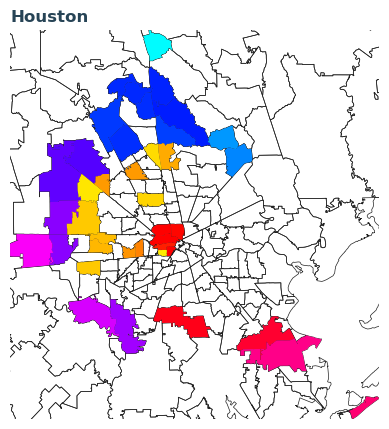

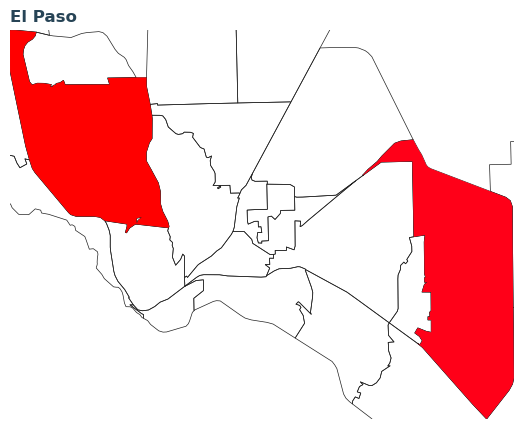

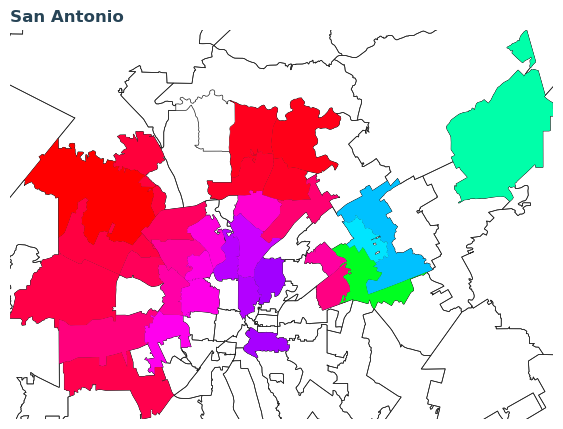

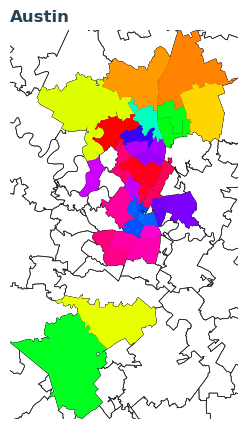

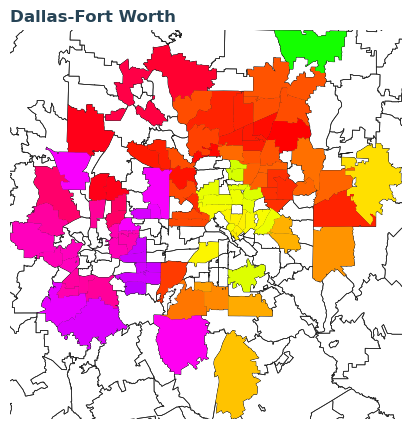

In [68]:
# lists of relevent zipcodes
houston_zips_list = list(target_zips[target_zips['City']=='Houston']['zip_code'].unique())
paso_zips_list = list(target_zips[target_zips['City']=='El Paso']['zip_code'].unique())
san_zips_list = list(target_zips[target_zips['City']=='San Antonio']['zip_code'].unique())
austin_zips_list = list(target_zips[target_zips['City']=='Austin']['zip_code'].unique())
dallas_zips_list = list(target_zips[target_zips['City']=='Dallas-Fort Worth']['zip_code'].unique())

# limitting the zips to just inside the region around TX 
zips = zips[zips['AFFGEOID10'].str[0:10] == '8600000US7'].reset_index()

# limiting to the inidvidual regions of interest
houston_zips = zips.loc[zips.loc[:,'GEOID10'].isin(houston_zips_list),:]
paso_zips = zips.loc[zips.loc[:,'GEOID10'].isin(paso_zips_list),:]
san_zips = zips.loc[zips.loc[:,'GEOID10'].isin(san_zips_list),:]
austin_zips = zips.loc[zips.loc[:,'GEOID10'].isin(austin_zips_list),:]
dallas_zips = zips.loc[zips.loc[:,'GEOID10'].isin(dallas_zips_list),:]

# dictionary of each cities zipcodes
different_metros = {'Houston' : houston_zips, 
                    'El Paso' : paso_zips, 
                    'San Antonio' : san_zips, 
                    'Austin' : austin_zips, 
                    'Dallas-Fort Worth' : dallas_zips}

# looping the graphing to make sure it works
for metro in different_metros.keys():
    fig,ax = plt.subplots()
    zip_boundry_map = zips.boundary.plot(color='#212121', linewidth=.5,ax=ax)
    different_metros[metro].plot(ax=zip_boundry_map, zorder=2, legend=False, column = 'GEOID10', cmap='hsv')

    zip_boundry_map.axis('off')

    minx, miny, maxx, maxy = different_metros[metro].total_bounds
    ax.set_xlim(minx, maxx)
    ax.set_ylim(miny, maxy)
    plt.title(metro)
    plt.show()

### now 12 month lag

In [85]:
# zri_shift 6-12 months
zri_shift, zri_shift_X_vals = helper.time_lag_merge(zri, zri, {
    12:['zori_ssa'],
    13:['zori_ssa'],
    18:['zori_ssa'],
    24:['zori_ssa']
},
                                          return_cols = True
                                         )
zri_shift = zri_shift.dropna(axis='index',how = 'any').reset_index(drop = True)
# Adding the shift values
zri_shift.loc[:,'zori_ssa_1_diff_lag_12'] = (zri_shift.loc[:,'zori_ssa_12_month_shift'] -
                                             zri_shift.loc[:,'zori_ssa_13_month_shift'])
zri_shift.loc[:,'zori_ssa_6_diff_lag_12'] = (zri_shift.loc[:,'zori_ssa_12_month_shift'] -
                                             zri_shift.loc[:,'zori_ssa_18_month_shift'])
zri_shift.loc[:,'zori_ssa_12_diff_lag_12'] = (zri_shift.loc[:,'zori_ssa_12_month_shift'] -
                                             zri_shift.loc[:,'zori_ssa_24_month_shift'])
zri_shift = zri_shift[['Time','zip_code','zori_ssa', 'zori_ssa_12_month_shift',
                       'zori_ssa_18_month_shift',
                       'zori_ssa_1_diff_lag_12', 'zori_ssa_6_diff_lag_12',
                       'zori_ssa_12_diff_lag_12']]
zri_shift['zori_ssa_12_diff_lag_12_per'] = (zri_shift['zori_ssa_12_diff_lag_12']/
                                           zri_shift['zori_ssa_12_month_shift'])



In [86]:
df_dict = {'zri':zri, 'weather':weather, 'sales_tax':sales_tax, 
           'shiller':shiller, 'polls':polls, 'monthly_tnx':monthly_tnx, 
           'gas':gas, 
           'env':env, 'daycare':daycare, 
           'covid':covid, 
           'unemployment':unemployment, 
#            'census:census, 
           'econ':econ, 'taxpayer':taxpayer, 'outlet':outlet}
for df in df_dict.keys():
    print('\n'+df+'===================')
    print(df_dict[df].head())
    date_range = str(df_dict[df]['Time'].dt.date.min()) + ' to ' +str(df_dict[df]['Time'].dt.date.max())
    print(f'{df}: {date_range}')
    df_columns = str(list(df_dict[df].columns))
    print(f'{df} columns: {df_columns}')


zri===================
        Time  zip_code  zori_ssa
0 2014-01-01     77494    1390.0
1 2014-02-01     77494    1387.0
2 2014-03-01     77494    1384.0
3 2014-04-01     77494    1381.0
4 2014-05-01     77494    1379.0
zri: 2014-01-01 to 2021-07-01
zri columns: ['Time', 'zip_code', 'zori_ssa']

weather===================
        Time  zip_code  mintempC   maxtempC  precipMM
0 2012-01-01     78727  6.806452  16.967742  2.419355
1 2012-01-01     78759  6.806452  16.967742  2.419355
2 2012-01-01     78681  6.806452  16.967742  2.419355
3 2012-01-01     78728  6.806452  16.967742  2.419355
4 2012-01-01     78634  6.806452  16.967742  2.419355
weather: 2012-01-01 to 2021-08-01
weather columns: ['Time', 'zip_code', 'mintempC', 'maxtempC', 'precipMM']

sales_tax===================
           Time  zip_code  sales_tax_rate  total_sales_tax  \
2580 2013-01-01     77494             1.0        832941.14   
2581 2013-01-01     77449             1.0        832941.14   
2582 2013-01-01     77084 

In [87]:
# weather 
weather_cols = ['mintempC', 'maxtempC', 'precipMM']
merge_shift, weather_X_vals = helper.time_lag_merge(zri_shift, 
                                                    weather, {
    12:weather_cols,
},
                                          return_cols = True
                                         )

# sales_tax
sales_tax_cols = ['sales_tax_rate', 'total_sales_tax']
merge_shift, shiller_X_vals = helper.time_lag_merge(merge_shift, sales_tax, {
    12:sales_tax_cols,
},
                                          return_cols = True
                                         )


# shiller
shiller_cols = ['sap_case_shiller_index']
merge_shift, shiller_X_vals = helper.time_lag_merge(merge_shift, shiller, {
    12:shiller_cols,
},
                                          return_cols = True
                                         )


polls_cols = ['tx_is_abt_same', 'tx_is_better', 'tx_is_worse']
# polls
merge_shift, polls_X_vals = helper.time_lag_merge(merge_shift, polls, {
    12:polls_cols,
},
                                          return_cols = True
                                         )


monthly_tnx_cols = ['TNX']
# monthly_tnx
merge_shift, monthly_tnx_X_vals = helper.time_lag_merge(merge_shift, monthly_tnx, {
    12:monthly_tnx_cols,
},
                                          return_cols = True
                                         )


gas_cols = ['monthly_avg_gas_price']
# gas
merge_shift, gas_X_vals = helper.time_lag_merge(merge_shift, gas, {
    12:gas_cols,
},
                                          return_cols = True
                                         )


covid_cols = ['fatalities', 'caseCount']
# covid
merge_shift, covid_X_vals = helper.time_lag_merge(merge_shift, covid, {
    12:covid_cols,
},
                                          return_cols = True
                                         )


unemployment_cols = ['ur', 'delta_ur']
# unemployment
merge_shift, unemployment_X_vals = helper.time_lag_merge(merge_shift, unemployment, {
    12:unemployment_cols,
},
                                          return_cols = True
                                         )



econ_cols = ['Consumer Confidence Index TX', 'Consumer Confidence West South Central', 
     'Consumer Confidence Index US', 'Consumer Price Index TX', 
     'Consumer Price Index U.S.', 'Nonfarm Employment TX', 'Nonfarm Employment U.S.', 
     'Unemployment TX', 'Unemployment U.S.', 'Single Family Building Permits TX', 
     'Multi Family Building Permits TX', 'Existing Single Family Home Sales TX', 
     'Existing Single Family Home Price TX', 'Non Residential Building Construction', 
     'Total Sales Tax Collections Retail TX', 'Total Sales Tax Collections TX', 
        'Retail Gasoline Price TX', 
     'Retail Diesel Price TX', 'Nonfarm Employment Illinois', 
        'Nonfarm Employment Florida', 
     'Nonfarm Employment New York', 'Nonfarm Employment Texas', 
        'Nonfarm Employment California', 
     'Gross Value Crude Oil Production', 'Gross Value Natural Gas Production', 
     'Motor Fuel Taxed Gasoline', 'Motor Fuel Taxed Diesel']
# econ
merge_shift, econ_X_vals = helper.time_lag_merge(merge_shift, econ, {
    12:econ_cols,
},
                                          return_cols = True
                                         )


taxpayer_cols = ['taxpayer_count',  'taxpayer_same_zip_ratio', 
 'taxpayer_cl_ratio', 'taxpayer_is_ratio', 'taxpayer_foreign_ratio']
# taxpayer
merge_shift, taxpayer_X_vals = helper.time_lag_merge(merge_shift, taxpayer, {
    12:taxpayer_cols,
},
                                          return_cols = True
                                         )

outlet_cols = ['outlet_count', 'outlet_non_tx_ratio', 
 'outlet_cl_ratio', 'outlet_is_ratio', 'outlet_foreign_ratio']
# outlet
zri_shift, outlet_X_vals = helper.time_lag_merge(merge_shift, outlet, {
    12: outlet_cols,
},
                                          return_cols = True
                                         )




In [88]:
zri_shift.shape

(14620, 61)

In [89]:
## future hayden figure out why there are infinities

In [90]:
zri_shift = zri_shift.replace([np.inf, -np.inf], np.nan).dropna(axis=0)
zri_shift.shape 

(14620, 61)

In [91]:

def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["features"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

In [92]:
#X_vals

In [276]:
X_vals = zri_shift.drop(columns = 
                                          ['Time','zip_code','zori_ssa']
                                         ).columns.to_list()
bad_X_vals = [
    'zori_ssa_18_month_shift',
    'zori_ssa_12_diff_lag_12',
    'Nonfarm Employment Texas_12_month_shift',
    'Retail Gasoline Price TX_12_month_shift',
    'Nonfarm Employment New York_12_month_shift',
    'Nonfarm Employment California_12_month_shift',
    'Existing Single Family Home Price TX_12_month_shift',
    'Nonfarm Employment Florida_12_month_shift',
    'Consumer Confidence Index US_12_month_shift',
    'Nonfarm Employment Illinois_12_month_shift',

    'Nonfarm Employment U.S._12_month_shift',
    'Consumer Price Index U.S._12_month_shift',
    'Consumer Confidence West South Central_12_month_shift',
    'Gross Value Crude Oil Production_12_month_shift',
    'Nonfarm Employment U.S._12_month_shift',
    'Total Sales Tax Collections Retail TX_12_month_shift',
    'Motor Fuel Taxed Gasoline_12_month_shift',
    'Total Sales Tax Collections TX_12_month_shift',
    'Motor Fuel Taxed Diesel_12_month_shift',
    'Consumer Price Index TX_12_month_shift',
    'Total Sales Tax Collections Retail TX_12_month_shift',
    'tx_is_better_12_month_shift',
    'ur_12_month_shift',
    'monthly_avg_gas_price_12_month_shift',
    'Retail Diesel Price TX_12_month_shift',
    'maxtempC_12_month_shift',
    'Nonfarm Employment TX_12_month_shift',
    'Unemployment TX_12_month_shift',
    'Unemployment U.S._12_month_shift',
    'Existing Single Family Home Sales TX_12_month_shift',
    'sap_case_shiller_index_12_month_shift',
    'Multi Family Building Permits TX_12_month_shift',
    'Single Family Building Permits TX_12_month_shift',
    'Consumer Confidence Index TX_12_month_shift',
    'TNX_12_month_shift',
    'outlet_cl_ratio_12_month_shift',
    'outlet_is_ratio_12_month_shift',
    'fatalities_12_month_shift',
    'outlet_foreign_ratio_12_month_shift',
    'Non Residential Building Construction_12_month_shift',
    'outlet_non_tx_ratio_12_month_shift',
    'outlet_count_12_month_shift',
    'tx_is_abt_same_12_month_shift',
    'taxpayer_same_zip_ratio_12_month_shift',
    'sales_tax_rate_12_month_shift',
    'caseCount_12_month_shift',
    #58 went up to 60. probably worth keeping in
#     'Gross Value Natural Gas Production_12_month_shift',
    'precipMM_12_month_shift',
    'delta_ur_12_month_shift',

    
             ]
X_vals = [X_val for X_val in X_vals if X_val not in bad_X_vals]
y_val = 'zori_ssa'

# for metro in metros:
train = zri_shift.loc[zri_shift['Time']<datetime.datetime(2020,7,2),:].reset_index(drop=True)
test = zri_shift.loc[zri_shift['Time']>datetime.datetime(2020,7,2),:].reset_index(drop=True)
# cat_feats_=[]

scaler = StandardScaler(with_mean=False)
lasso = Lasso(max_iter = 50000, random_state = 33)

X = train[X_vals]
# transformer = ColumnTransformer([("Cat", 
#                                   OneHotEncoder(handle_unknown = 'ignore'), 
#                                   cat_feats_)], remainder='passthrough')
# X = transformer.fit_transform(X)
X = scaler.fit_transform(X)
y = train[y_val]

In [277]:
X_w_cols = pd.DataFrame(X, columns=X_vals)

vif = calc_vif(X_w_cols)

In [278]:
# X_vals = ['zori_ssa_12_month_shift',
#             'zori_ssa_18_month_shift',
#             'zori_ssa_1_diff_lag_12', 'zori_ssa_6_diff_lag_12',
#             'zori_ssa_12_diff_lag_12_per',
#                        ] + acs_X_vals
# y_val = 'zori_ssa'

# # for metro in metros:
# train = zri_shift.loc[zri_shift['Time']<datetime.datetime(2020,7,2),:].reset_index(drop=True)
# test = zri_shift.loc[zri_shift['Time']>datetime.datetime(2020,7,2),:].reset_index(drop=True)
# cat_feats_=[]

# scaler = StandardScaler(with_mean=False)
# lasso = Lasso(max_iter = 50000, random_state = 33)

# X = train[X_vals]
# # transformer = ColumnTransformer([("Cat", 
# #                                   OneHotEncoder(handle_unknown = 'ignore'), 
# #                                   cat_feats_)], remainder='passthrough')
# # X = transformer.fit_transform(X)
# X = scaler.fit_transform(X)
# y = train[y_val]

# Grid Search set up.

alphas = [0.3, 0.6, 1]
tuned_parameters = [{'alpha': alphas}]
print(f'Performing Grid Search with alphas of: {alphas}')
clf = GridSearchCV(lasso, tuned_parameters, 
                    cv=3,n_jobs = -1,
                  scoring = 'neg_root_mean_squared_error')
# best_alpha = clf.best_params_['alpha']
clf.fit(X, y)

X_test = test[X_vals]
# X_test = transformer.transform(X_test)
X_test = scaler.transform(X_test)
y_test = test[y_val]
y_predicted = clf.predict(X_test)
test.loc[:,'pred_difference'] = test.loc[:,y_val] - y_predicted

rms = mean_squared_error(y_test, y_predicted, squared=False)
test.loc[:,'pred'] = y_predicted


Performing Grid Search with alphas of: [0.3, 0.6, 1]


In [279]:
coef_df = pd.DataFrame({'features':test[X_vals].columns,'coefs':clf.best_estimator_.coef_})
coef_df = coef_df[coef_df['coefs']!=0]
coef_df['coefs_abs'] = abs(coef_df['coefs'])
coef_df = coef_df.sort_values('coefs_abs',ascending=False).reset_index(drop=True)
coef_df

,features,coefs,coefs_abs
0,zori_ssa_12_month_shift,234.922555,234.922555
1,zori_ssa_1_diff_lag_12,22.767122,22.767122
2,zori_ssa_6_diff_lag_12,-11.074098,11.074098
3,total_sales_tax_12_month_shift,-4.702458,4.702458
4,zori_ssa_12_diff_lag_12_per,3.371872,3.371872
5,tx_is_worse_12_month_shift,-1.355487,1.355487
6,Gross Value Natural Gas Production_12_month_shift,-1.099396,1.099396
7,taxpayer_cl_ratio_12_month_shift,-1.034684,1.034684
8,mintempC_12_month_shift,-0.842381,0.842381
9,taxpayer_count_12_month_shift,-0.739504,0.739504


/Users/haydenlw4/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


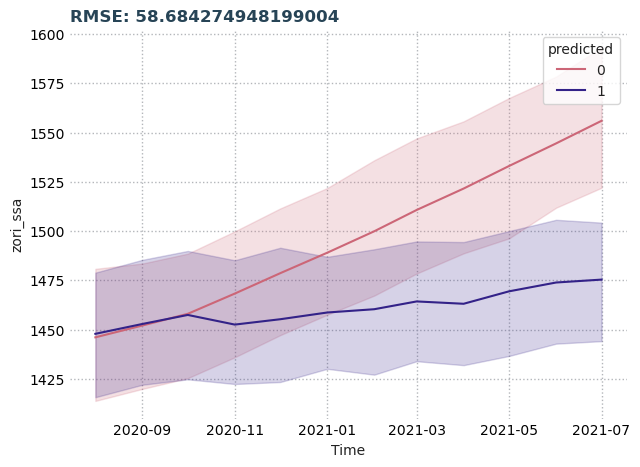

In [280]:
graph_df1 = test[['Time',y_val]]
graph_df1.loc[:,'predicted'] = 0 
graph_df2 = test[['Time','pred']].rename(columns={'pred':y_val})
graph_df2.loc[:,'predicted'] = 1
graph_df = pd.concat([graph_df1,graph_df2]).reset_index(drop=True)

g = sns.lineplot(data = graph_df, x = 'Time',y = y_val, hue = 'predicted')
plt.title(f'RMSE: {rms}')
plt.show()

In [282]:
vif.merge(coef_df,how='left',left_on='features',right_on='features').sort_values('VIF',
                                                                                ascending=False)

vif = vif.reset_index(drop=True)
vif.loc[:,'features'] = [feature.replace('_12_mont_shift', '') for feature in vif.loc[:,'features']]
vif.to_csv('non_acs_raw_after_vif.csv')

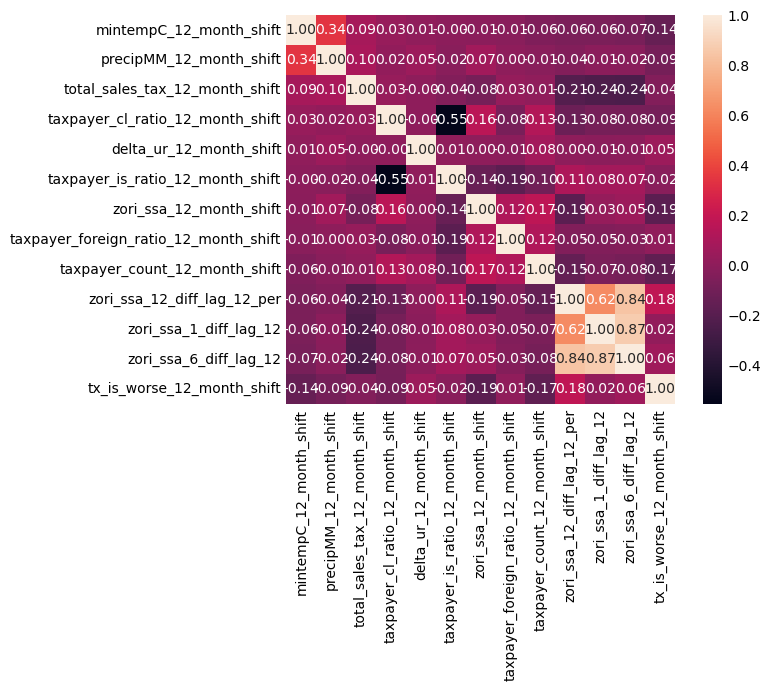

In [242]:
corr_feat_pick = 'mintempC_12_month_shift'

k = 15 #number of variables for heatmap
cols = X_w_cols.corr().nlargest(k, corr_feat_pick)[corr_feat_pick].index
cm = np.corrcoef(X_w_cols[cols].values.T)
# sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [222]:
cols


Index(['sales_tax_rate_12_month_shift', 'taxpayer_is_ratio_12_month_shift',
       'zori_ssa_6_diff_lag_12', 'zori_ssa_1_diff_lag_12',
       'zori_ssa_12_diff_lag_12_per', 'zori_ssa_12_month_shift',
       'Gross Value Natural Gas Production_12_month_shift',
       'tx_is_worse_12_month_shift', 'delta_ur_12_month_shift',
       'precipMM_12_month_shift', 'mintempC_12_month_shift',
       'taxpayer_count_12_month_shift', 'taxpayer_cl_ratio_12_month_shift',
       'taxpayer_foreign_ratio_12_month_shift',
       'total_sales_tax_12_month_shift'],
      dtype='object')

In [ ]:
graph_df = test
graph_df['month'] = graph_df['Time'].dt.month
g = sns.boxplot(data = graph_df, x = 'Time',y = 'pred_difference', 
                )
plt.title(f'RMSE: {rms}')
plt.show()

In [ ]:
test['pred_12_month_growth'] = test['pred'] - test['zori_ssa_12_month_shift']
test['actual_12_month_growth'] = test['zori_ssa'] - test['zori_ssa_12_month_shift']

test['pred_12_month_growth_per'] = test['pred_12_month_growth']/test['zori_ssa_12_month_shift']
test['actual_12_month_growth_per'] = test['actual_12_month_growth']/test['zori_ssa_12_month_shift']
test['pred_difference_per'] = test['pred_difference']/test['zori_ssa_12_month_shift']
# test['month'] = test['Time'].dt.month

g = sns.scatterplot(data = test, x = 'pred_12_month_growth_per', 
                y = 'actual_12_month_growth_per', hue='Time')

sns.move_legend(g,"upper left", bbox_to_anchor=(1, 1))
plt.show()

In [ ]:
g = sns.JointGrid(data=test, x = 'pred_12_month_growth_per', 
                y = 'actual_12_month_growth_per', hue='Time',
                 )


g.plot_joint(sns.scatterplot,)
g.plot_marginals(sns.kdeplot,legend=False)

g.ax_joint.legend(loc='center left',bbox_to_anchor=(1.25, .5))
x0, x1 = g.ax_joint.get_xlim()
y0, y1 = g.ax_joint.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
g.ax_joint.plot(lims, lims, color = '#212121',linewidth=3,linestyle = 'dotted')

plt.show()

In [ ]:

for month in test.Time.unique():
    g = sns.JointGrid(data=test[test['Time']==month], x = 'pred_12_month_growth_per', 
                    y = 'actual_12_month_growth_per', hue='Time',
                     )


    g.plot_joint(sns.scatterplot,)
    g.plot_marginals(sns.kdeplot,legend=False)

    g.ax_joint.legend(loc='center left',bbox_to_anchor=(1.25, .5))
    x0, x1 = g.ax_joint.get_xlim()
    y0, y1 = g.ax_joint.get_ylim()
    lims = [max(x0, y0), min(x1, y1)]
    g.ax_joint.plot(lims, lims, color = '#212121',linewidth=3,linestyle = 'dotted')
    g.fig.suptitle("")
    plt.show()

In [ ]:
map_ = test
# dictionary of each cities zipcodes
different_metros = {'Houston' : houston_zips, 
                    'El Paso' : paso_zips, 
                    'San Antonio' : san_zips, 
                    'Austin' : austin_zips, 
                    'Dallas-Fort Worth' : dallas_zips}

# looping the graphing to make sure it works
for metro in different_metros.keys():


    graph_df = different_metros[metro].merge(map_, right_on='zip_code' ,left_on='GEOID10')
    fig,ax = plt.subplots()
    zip_boundry_map = zips.boundary.plot(color='#212121', linewidth=.5,ax=ax)
    graph_df.plot(ax=zip_boundry_map, 
                     column = graph_df["actual_12_month_growth_per"], 
    #               scheme='equal_interval', k=4,
                  legend=True,
                    )

    zip_boundry_map.axis('off')

    minx, miny, maxx, maxy = graph_df.total_bounds
    ax.set_xlim(minx, maxx)
    ax.set_ylim(miny, maxy)
    plt.title(metro +' Actual actual_12_month_growth_per\nBy Zip Code')
    plt.show()

In [ ]:
map_ = test
# dictionary of each cities zipcodes
different_metros = {'Houston' : houston_zips, 
                    'El Paso' : paso_zips, 
                    'San Antonio' : san_zips, 
                    'Austin' : austin_zips, 
                    'Dallas-Fort Worth' : dallas_zips}

# looping the graphing to make sure it works
for metro in different_metros.keys():


    graph_df = different_metros[metro].merge(map_, right_on='zip_code' ,left_on='GEOID10')
    fig,ax = plt.subplots()
    zip_boundry_map = zips.boundary.plot(color='#212121', linewidth=.5,ax=ax)
    graph_df.plot(ax=zip_boundry_map, 
                     column = graph_df["pred_difference_per"], 
    #               scheme='equal_interval', k=4,
                  legend=True,
                    )

    zip_boundry_map.axis('off')

    minx, miny, maxx, maxy = graph_df.total_bounds
    ax.set_xlim(minx, maxx)
    ax.set_ylim(miny, maxy)
    plt.title(metro+' Predicted pred_difference_per\nBy Zip Code')
    plt.show()

In [ ]:
five_per_zips = list(test[test['pred_12_month_growth_per']>.05].zip_code.unique())
naive_five_per_zips = list(test[test['zori_ssa_12_diff_lag_12_per']>.05].zip_code.unique())


In [ ]:
test.loc[:,'invest_rec_5_per'] = 0
test.loc[test['zip_code'].isin(five_per_zips),'invest_rec_5_per'] = 3
test.loc[test['zip_code'].isin(naive_five_per_zips),'invest_rec_5_per'] = 1
test.loc[(test['zip_code'].isin(naive_five_per_zips) &
          test['zip_code'].isin(five_per_zips))
          ,'invest_rec_5_per'] = 2


In [ ]:
test.loc[test['invest_rec_5_per']==3,'zip_code'].unique()

In [ ]:
color = ['#882255','#cc6677','#88ccee','#332288']
zips_code = [0,1,2,3]
color_mapping = dict(zip(zips_code,color))

map_ = test
# dictionary of each cities zipcodes
different_metros = {'Houston' : houston_zips, 
                    'El Paso' : paso_zips, 
                    'San Antonio' : san_zips, 
                    'Austin' : austin_zips, 
                    'Dallas-Fort Worth' : dallas_zips}

# looping the graphing to make sure it works
for metro in different_metros.keys():
    graph_df = different_metros[metro].merge(map_, right_on='zip_code' ,left_on='GEOID10')
    fig,ax = plt.subplots()
    zip_boundry_map = zips.boundary.plot(color='#212121', linewidth=.5,ax=ax)
    graph_df.plot(ax=zip_boundry_map, 
#                      column = graph_df["invest_rec_5_per"], 
                  color=graph_df["invest_rec_5_per"].map(color_mapping),
                  legend=True,
                    )

    zip_boundry_map.axis('off')

    minx, miny, maxx, maxy = graph_df.total_bounds
    ax.set_xlim(minx, maxx)
    ax.set_ylim(miny, maxy)
    plt.title(metro +' invest_rec_5_per\nBy Zip Code')
    plt.show()

In [ ]:
g = sns.JointGrid(data=test, x = 'pred_12_month_growth_per', 
                y = 'actual_12_month_growth_per', hue='invest_rec_5_per',
                 )


g.plot_joint(sns.scatterplot,)
g.plot_marginals(sns.kdeplot,legend=False)

g.ax_joint.legend(loc='center left',bbox_to_anchor=(1.25, .5))
x0, x1 = g.ax_joint.get_xlim()
y0, y1 = g.ax_joint.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
g.ax_joint.plot(lims, lims, color = '#212121',linewidth=3,linestyle = 'dotted')

plt.show()

In [ ]:
graph_df = test
graph_df['month'] = graph_df['Time'].dt.month
g = sns.boxplot(data = graph_df, x = 'invest_rec_5_per',y = 'actual_12_month_growth_per', 
                )
plt.title(f'RMSE: {rms}')
plt.show()

In [ ]:
# # zri_shift 6-12 months
# zri_shift, zri_shift_X_vals = helper.time_lag_merge(zri, zri, {
#     6:['zori_ssa'],
#     7:['zori_ssa'],
#     12:['zori_ssa'],
#     18:['zori_ssa']
# },
#                                           return_cols = True
#                                          )
# zri_shift = zri_shift.dropna(axis='index',how = 'any').reset_index(drop = True)
# # Adding the shift values
# zri_shift.loc[:,'zori_ssa_1_diff__lag_6'] = (zri_shift.loc[:,'zori_ssa_6_month_shift'] -
#                                              zri_shift.loc[:,'zori_ssa_7_month_shift'])
# zri_shift.loc[:,'zori_ssa_6_diff_lag_6'] = (zri_shift.loc[:,'zori_ssa_6_month_shift'] -
#                                              zri_shift.loc[:,'zori_ssa_12_month_shift'])
# zri_shift.loc[:,'zori_ssa_12_diff_lag_6'] = (zri_shift.loc[:,'zori_ssa_6_month_shift'] -
#                                              zri_shift.loc[:,'zori_ssa_18_month_shift'])
# zri_shift = zri_shift[['Time','zip_code','zori_ssa','zori_ssa_6_month_shift',
#                        'zori_ssa_12_month_shift',
#                        'zori_ssa_1_diff__lag_6','zori_ssa_6_diff_lag_6',
#                        'zori_ssa_12_diff_lag_6']]


In [ ]:
# X_vals = ['zori_ssa_6_month_shift',
#                        'zori_ssa_12_month_shift',
#                        'zori_ssa_1_diff__lag_6','zori_ssa_6_diff_lag_6',
#                        'zori_ssa_12_diff_lag_6']
# y_val = 'zori_ssa'

# # for metro in metros:
# train = zri_shift.loc[zri_shift['Time']<datetime.datetime(2021,1,2),:].reset_index(drop=True)
# test = zri_shift.loc[zri_shift['Time']>datetime.datetime(2021,1,2),:].reset_index(drop=True)
# cat_feats_=[]

# scaler = StandardScaler(with_mean=False)
# lasso = Lasso(max_iter = 50000, random_state = 33)

# X = train[X_vals]
# transformer = ColumnTransformer([("Cat", 
#                                   OneHotEncoder(handle_unknown = 'ignore'), 
#                                   cat_feats_)], remainder='passthrough')
# X = transformer.fit_transform(X)
# X = scaler.fit_transform(X)
# y = train[y_val]

# # Grid Search set up.

# alphas = [0.3, 0.6, 1]
# tuned_parameters = [{'alpha': alphas}]
# print(f'Performing Grid Search with alphas of: {alphas}')
# clf = GridSearchCV(lasso, tuned_parameters, 
#                     cv=3,n_jobs = -1,
#                   scoring = 'neg_root_mean_squared_error')
# # best_alpha = clf.best_params_['alpha']
# clf.fit(X, y)

# X_test = test[X_vals]
# X_test = transformer.transform(X_test)
# X_test = scaler.transform(X_test)
# y_test = test[y_val]
# y_predicted = clf.predict(X_test)
# test.loc[:,'pred_difference'] = test.loc[:,y_val] - y_predicted

# rms = mean_squared_error(y_test, y_predicted, squared=False)
# test.loc[:,'pred'] = y_predicted

In [ ]:
# test['pred_6_month_growth'] = test['pred'] - test['zori_ssa_6_month_shift']
# test['actual_6_month_growth'] = test['zori_ssa'] - test['zori_ssa_6_month_shift']

In [ ]:
# test['pred_6_month_growth_per'] = test['pred_6_month_growth']/test['zori_ssa_6_month_shift']
# test['actual_6_month_growth_per'] = test['actual_6_month_growth']/test['zori_ssa_6_month_shift']
# test['pred_difference_per'] = test['pred_difference']/test['zori_ssa_6_month_shift']
# test['month'] = test['Time'].dt.month


In [ ]:
# g = sns.scatterplot(data = test, x = 'pred_6_month_growth_per', 
#                 y = 'actual_6_month_growth_per', hue='Time')

# sns.move_legend(g,"upper left", bbox_to_anchor=(1, 1))
# plt.show()

In [ ]:
# g = sns.JointGrid(data=test, x = 'pred_6_month_growth_per', 
#                 y = 'actual_6_month_growth_per', hue='Time',
#                  )


# g.plot_joint(sns.scatterplot,)
# g.plot_marginals(sns.kdeplot,legend=False)

# g.ax_joint.legend(loc='center left',bbox_to_anchor=(1.25, .5))
# x0, x1 = g.ax_joint.get_xlim()
# y0, y1 = g.ax_joint.get_ylim()
# lims = [max(x0, y0), min(x1, y1)]
# g.ax_joint.plot(lims, lims, color = '#212121',linewidth=3,linestyle = 'dotted')

# plt.show()

In [ ]:
# g = sns.scatterplot(data = test, x = 'pred_6_month_growth', y = 'actual_6_month_growth', 
#                hue = 'Time')

# sns.move_legend(g,"upper left", bbox_to_anchor=(1, 1))

# plt.show()

In [ ]:
# sns.scatterplot(data = test, x = 'pred_6_month_growth', y = 'actual_6_month_growth', 
#                hue = 'pred_difference')
# plt.show()

In [ ]:
# sns.scatterplot(data = test[test['month']==7], x = 'pred_6_month_growth', y = 'actual_6_month_growth', 
#                hue = 'pred_difference')
# plt.show()

In [ ]:
# graph_df1 = test[['Time',y_val]]
# graph_df1.loc[:,'predicted'] = 0 
# graph_df2 = test[['Time','pred']].rename(columns={'pred':y_val})
# graph_df2.loc[:,'predicted'] = 1
# graph_df = pd.concat([graph_df1,graph_df2]).reset_index(drop=True)

# g = sns.lineplot(data = graph_df, x = 'Time',y = y_val, hue = 'predicted')
# plt.title(f'RMSE: {rms}')
# plt.show()

In [ ]:
# sns.lineplot(data = zri,  x = 'Time',y = y_val)
# plt.show()

In [ ]:
# graph_df = test
# graph_df['month'] = graph_df['Time'].dt.month
# g = sns.boxplot(data = graph_df, x = 'month',y = 'pred_difference', 
#                 )
# plt.title(f'RMSE: {rms}')
# plt.show()

In [ ]:
# coef_df = pd.DataFrame({'features':test[X_vals].columns,'coefs':clf.best_estimator_.coef_})
# coef_df = coef_df[coef_df['coefs']!=0]
# coef_df['coefs_abs'] = abs(coef_df['coefs'])
# coef_df = coef_df.sort_values('coefs_abs',ascending=False).reset_index(drop=True)
# coef_df

In [ ]:
# map_ = test[test['Time'].dt.month==4]
# # dictionary of each cities zipcodes
# different_metros = {'Houston' : houston_zips, 
#                     'El Paso' : paso_zips, 
#                     'San Antonio' : san_zips, 
#                     'Austin' : austin_zips, 
#                     'Dallas-Fort Worth' : dallas_zips}

# # looping the graphing to make sure it works
# for metro in different_metros.keys():


#     graph_df = different_metros[metro].merge(map_, right_on='zip_code' ,left_on='GEOID10')
#     fig,ax = plt.subplots()
#     zip_boundry_map = zips.boundary.plot(color='#212121', linewidth=.5,ax=ax)
#     graph_df.plot(ax=zip_boundry_map, 
#                      column = graph_df["pred_difference"], 
#     #               scheme='equal_interval', k=4,
#                   legend=True,
#                     )

#     zip_boundry_map.axis('off')

#     minx, miny, maxx, maxy = graph_df.total_bounds
#     ax.set_xlim(minx, maxx)
#     ax.set_ylim(miny, maxy)
#     plt.title(metro+' Predicted Difference\nBy Zip Code')
#     plt.show()

In [ ]:
# map_ = test[test['Time'].dt.month==4]
# # dictionary of each cities zipcodes
# different_metros = {'Houston' : houston_zips, 
#                     'El Paso' : paso_zips, 
#                     'San Antonio' : san_zips, 
#                     'Austin' : austin_zips, 
#                     'Dallas-Fort Worth' : dallas_zips}

# # looping the graphing to make sure it works
# for metro in different_metros.keys():


#     graph_df = different_metros[metro].merge(map_, right_on='zip_code' ,left_on='GEOID10')
#     fig,ax = plt.subplots()
#     zip_boundry_map = zips.boundary.plot(color='#212121', linewidth=.5,ax=ax)
#     graph_df.plot(ax=zip_boundry_map, 
#                      column = graph_df["zori_ssa"], 
#     #               scheme='equal_interval', k=4,
#                   legend=True,
#                     )

#     zip_boundry_map.axis('off')

#     minx, miny, maxx, maxy = graph_df.total_bounds
#     ax.set_xlim(minx, maxx)
#     ax.set_ylim(miny, maxy)
#     plt.title(metro +' Actual ZRI\nBy Zip Code')
#     plt.show()